
# Приоритизация гипотез и анализ A/B-теста для интернет-магазина.

---

В нашем распоряжении файлы, содержащие ряд гипотез для увеличения выручки, а также результаты A/B-теста.
\
В исследовании мы применим ряд фреймворков и выберем наиболее приоритетные гипотезы, а также проанализируем результаты A/B-теста.

**Цели исследования**

* выяснить наиболее перспективную гипотезу
* проанализировать результаты A/B-теста и принять решение о продолжении теста или его остановки
* yзнать, есть ли значимая разница между группами `A` и `B`, на основе уже имеющихся данных

---
**Ход исследования**

Данные мы получили из нескольких файлов. О качестве данных пока ничего не известно.
Поэтому перед проведением исследования нам понадобится обзор данных.

Таким образом, исследование пройдёт в несколько этапов:

1 — Обзор данных\
2 — Предобработка данных\
3 — Приоритизация гипотез\
4 — Анализ A/B-теста и принятие решения на основе выводов\
5 — Общий вывод

---
**Описание данных**

**Данные для выбора приоритетной гипотезы**

Файл `/datasets/hypothesis.csv.`:

`Hypothesis` — краткое описание гипотезы\
`Reach` — охват пользователей по 10-балльной шкале\
`Impact` — влияние на пользователей по 10-балльной шкале\
`Confidence` — уверенность в гипотезе по 10-балльной шкале\
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Данные с результатами A/B-теста**

Файл `/datasets/orders.csv`\

`transactionId` — идентификатор заказа\
`visitorId` — идентификатор пользователя, совершившего заказ\
`date` — дата, когда был совершён заказ\
`revenue` — выручка заказа\
`group` — группа A/B-теста, в которую попал заказ.


Файл `/datasets/visitors.csv`:\

`date` — дата\
`group` — группа A/B-теста\
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

<div class="alert alert-info">В ходе проекта использован код, данный в главе теории к проекту.
В ходе проекта, я укажу на него такими голубыми ячейками.
</div>

## Обзор данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
#сохраняем файлы в датафреймы
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
pd.options.display.max_colwidth = 1 # настраиваем максимальную ширину столбца

Начнем с датасета `hypothesis`.\
Выведем на экран первые строки датасета и применим метод info():

In [4]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


**Наблюдения**

* Пропусков и дубликатов в датасете нет
* Желательно привести названия столбцов к змеиному регистру
* Типы данных в датасете корректные

Теперь изучим `orders`.\
Выведем на экран первые строки датасета и применим метод info():

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


**Наблюдения**

* Пропусков в датасете нет
* Желательно привести названия столбцов к змеиному регистру
* Нужно изменить тип данных столбца `date` с object на datetime
* Следует проверить датасет на дубликаты
* Нужно проверить нет ли пользователей, попавших в обе группы исследования

Перейдем к датасету `visitors`.\
Выведем на экран первые строки датасета и применим метод info():

In [8]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Наблюдения**

* Пропусков в датасете нет
* Нужно изменить тип данных столбца `date` с object на datetime
* Следует проверить датасет на дубликаты

### Промежуточный вывод

Мы изучили полученные для исследования данных и выяснили необходимые шаги для предобработки.\
Далее подготовим файлы для работы:

**`hypothesis`**

* приведем названия столбцов к змеиному регистру

**`orders`**

* приведем названия столбцов к змеиному регистру
* изменим тип данных столбца `date` с object на datetime
* проверим датасет на дубликаты
* проверим нет ли пользователей, попавших в обе группы

**`visitors`**

* изменим тип данных столбца `date` с object на datetime
* проверим датасет на дубликаты

## Предобработка данных

### Переименование столбцов

In [10]:
#переводим названия столбцов в змеиный регистр
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'transactionid': 'transaction_id','visitorid':'visitor_id'})

#проверка
display(orders.columns)
hypothesis.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### Изменение типов данных

In [11]:
#переводим столбцы `date` в датасетах orders и visitors в тип datetime
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

#проверка
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Поиск дубликатов

#### Поиск явных дубликатов

In [12]:
orders.duplicated().sum()

0

In [13]:
visitors.duplicated().sum()

0

Полностью повторяющихся строк нет. 

---
#### Поиск неявных дубликатов:

В датасете `orders`:

* В столбце `transaction_id` должны быть только уникальные значения
* В столбце `group` должны быть только значения `A и B`


В датасете `visitors`:

* В столбце `group` должны быть только значения `A и B`
* В столбце `date` каждая дата должна появляться 2 раза

Проверим вышеуказанные столбцы.

In [14]:
# столбце transaction_id датасета orders считаем сколько максимально выстречаются уникальные значения
orders['transaction_id'].value_counts().max()

1

In [15]:
# столбце group датасета orders и visitors проверяем уникальные значения
display(orders['group'].unique())
visitors['group'].unique()

array(['B', 'A'], dtype=object)

array(['A', 'B'], dtype=object)

In [16]:
# столбце date датасета visitors считаем сколько максимально и минимально выстречаются уникальные даты
display(visitors['date'].value_counts().max())
visitors['date'].value_counts().min()

2

2

### Проверка распределения пользователей по группам

Проверим нет ли пользователей, который попали сразу в обе группы. Для этого создадим срезы по группам и найдем строки, в которых id посетителя совпадает для обеих групп.

In [17]:
wrong_orders = orders.query('group == "B"').merge(orders.query('group == "A"'),on='visitor_id')

wrong_orders.head()

,transaction_id_x,visitor_id,date_x,revenue_x,group_x,transaction_id_y,date_y,revenue_y,group_y
0,2904772834,963407295,2019-08-15,300,B,1458356232,2019-08-14,4940,A
1,4252514150,351125977,2019-08-15,15185,B,3075639014,2019-08-06,4485,A
2,1162046357,3234906277,2019-08-15,7555,B,1360774578,2019-08-18,7555,A
3,1630050528,237748145,2019-08-15,7620,B,2594268419,2019-08-15,1090,A
4,1630050528,237748145,2019-08-15,7620,B,3702128013,2019-08-20,1290,A


Теперь создадим список пользователей, которые появляются в обеих группах

In [18]:
delete_users = wrong_orders['visitor_id'].unique().tolist()
len(delete_users)

58

Таких пользователей — 58, теперь отфильтруем заказы, сделанные этими пользователями из исходного датафрейма.

In [19]:
print('Количество строк в таблице orders до фильтрации —', orders.shape[0])

#фильтруем таблицу
orders = orders.query('visitor_id not in @delete_users')

print('Количество строк в таблице orders после фильтрации —', orders.shape[0])

#Проверим, остались ли в таблице пользователи, которые попадают в обе группы
orders.query('group == "B"').merge(orders.query('group == "A"'),on='visitor_id')

Количество строк в таблице orders до фильтрации — 1197
Количество строк в таблице orders после фильтрации — 1016


,transaction_id_x,visitor_id,date_x,revenue_x,group_x,transaction_id_y,date_y,revenue_y,group_y


Теперь в каждой группе остались только уникальные для группы пользователи.

#### Промежуточный вывод

Мы подготовили датасеты к работе:

Переименовали столбцы, проверили на наличие явных и неявных дубликатов, исправили, где это необходимо тип данных.Также проверили датасет orders на наличие пользователей, попавших в обе группы и удалили заказы таких пользователей из таблицы\
Можно приступать к заданиям.

###  Приоритизация гипотез.

#### Фреймворк ICE

Для начала снова выведем датасет `hypothesis`, содержащего информацию о гипотезах на экран:

In [20]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Для вычисления ICE мы будем использовать формулу **ICE Score = (Impact * Confidence / Efforts)**

Добавим в существующую таблицу новый столбец `ice` и выведем полученные данные с сортировкой по убыванию приоритета.

In [21]:
hypothesis['ice'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'],2)
hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Наблюдения**

* Наиболее приоритетная гипотеза №8
* В топ 3 попали гипотезы №№ 8,0,7
* Наименее приоритетная гипотеза №4

#### Фреймворк RICE

Для вычисления RICE мы будем использовать формулу **RICE Score = (Reach * Impact * Confidence / Efforts)**

Добавим в существующую таблицу новый столбец `rice` и выведем полученные данные с сортировкой по убыванию приоритета.

In [22]:
hypothesis['rice'] = round(hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'],2)
hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Наблюдения**

* Наиболее приоритетной стала гипотеза №7
* В топ 3 попали гипотезы №№ 7,2,0
* Наименее приоритетна опять гипотеза №4

####  Промежуточный вывод

Мы применили два способа приоритизации гипотез RICE и ICE. 

* При применении способа ICE в топ 3 попали гипотезы №№ 8,0,7, с №8 на первом месте.
* После применения способа RICE на первое место по приоритетности вышла гипотеза №7
№8 ушла в середину списка, 0 остался в топ 3, также в топ 3 поднялась гипотеза под номером №2
* на последнем месте в обоих случая гипотеза №4

На изменение положения гипотез в шкале приоритетности повлиял параметр `reach` (англ. «охват»).\
У гипотезы **№8** ("Запустить акцию, дающую скидку на товар в день рождения") этот параметр всего 1 из 10, поэтому она опустилась в середину списка.\
У гипотезы **№7** ("Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок") параметр `reach`, напротив, 10 из 10, что стало причиной его попадания на 1-е место при оценке RICE.

### Анализ A/B-теста

####  График кумулятивной выручки по группам

Выведем на экран первые строки датасетов `orders` и `visitors`

In [23]:
display(orders.head())
visitors.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Для создания графиков создадим переменную `cumulativeData` со столбцами: 
* `date` — дата;
* `group` — группа A/B-теста (A или B)
* `order`s — кумулятивное количество заказов на указанную дату в указанной группе
* `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе
* `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек)
* `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

In [24]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

#выведем 5 первый строк получившейся таблицы на экран
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


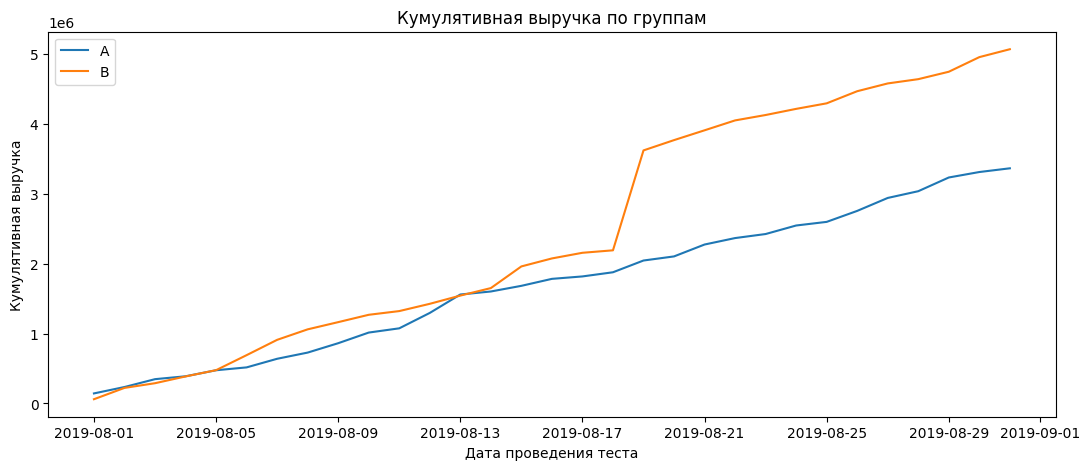

In [25]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(13, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

#прописываем оси и названия
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата проведения теста') 
plt.ylabel('Кумулятивная выручка');

plt.legend();

**Промежуточный вывод**

* У группы `A` выручка растет равномерно в течении всего времени
* У группы `B` наблюдается резкий всплеск 19-го августа это может свидетельствовать об аномально дорогих заказах. Выясним аномально дорогие заказы, а также пользователей, которые совершили аномально много покупок позже. Группа `B` опережает группу `A` после 13 августа.

####  График кумулятивного среднего чека по группам

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

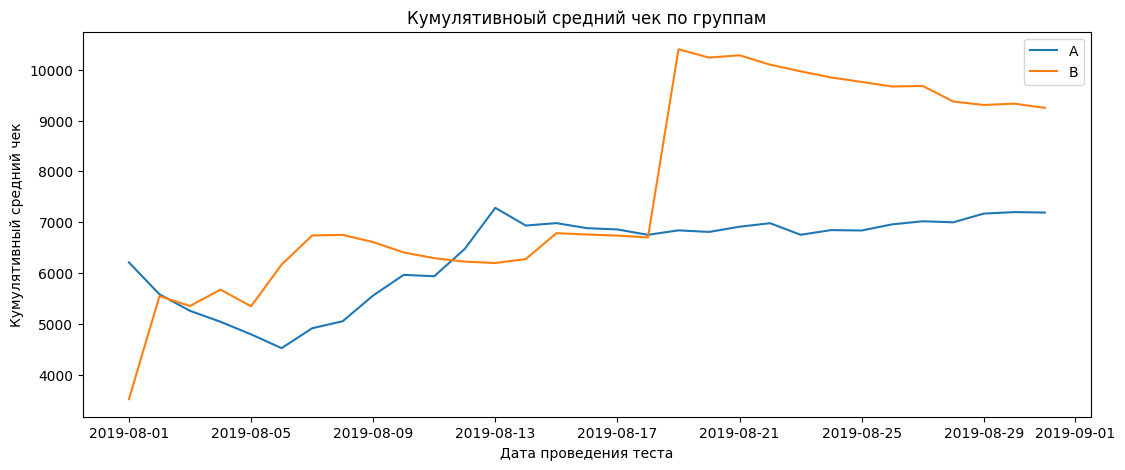

In [26]:
plt.figure(figsize=(13, 5))

# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

#прописываем оси и названия
plt.title('Кумулятивноый средний чек по группам')
plt.xlabel('Дата проведения теста') 
plt.ylabel('Кумулятивный средний чек')

plt.legend();

**Промежуточный вывод**

* у группы `A` средний становится равномерным ближе к концу теста
* У группы `B` опять наблюдается резкий скачок 19 августа, и потом понемногу начинает падать, при этом группа `B` после 15 числа стабильно опережает группу `A`

#### График относительного изменения кумулятивного среднего чека группы B к группе A

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

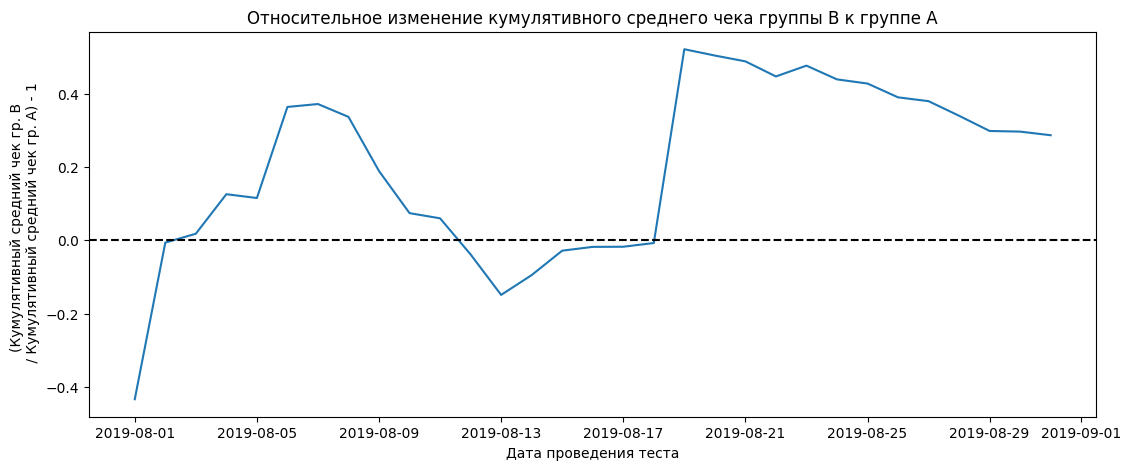

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(13, 5))


plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']
          /mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']
           /mergedCumulativeRevenue['ordersA'])-1)

#прописываем оси и названия
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата проведения теста') 
plt.ylabel('(Кумулятивный средний чек гр. B \n / Кумулятивный средний чек гр. А) - 1')


# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

**Промежуточный вывод**

* График резко проседает после 7 августа и резко растет 19-го. Причиной первого пика стало то, что 6-7 августа средний чек группы B стал расти, а средний чек группы A — падать, соответственно их отношение резко начало расти, что и вызвало пик на графике.
* После 19-го и до конца периода наблюдений отношение понемногу падает.
* Отношение (B/A-1) почти все время больше ноля (30% к концу наблюдений).

#### График кумулятивного среднего количества заказов на посетителя по группам

Думаю, тут дело в том, что именно в даты первого пика (6-7 августа)
средний чек группы B стал расти, а средний чек группы A — падать, соответственно их отношение резко начало расти, что и вызвало пик на графике.

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

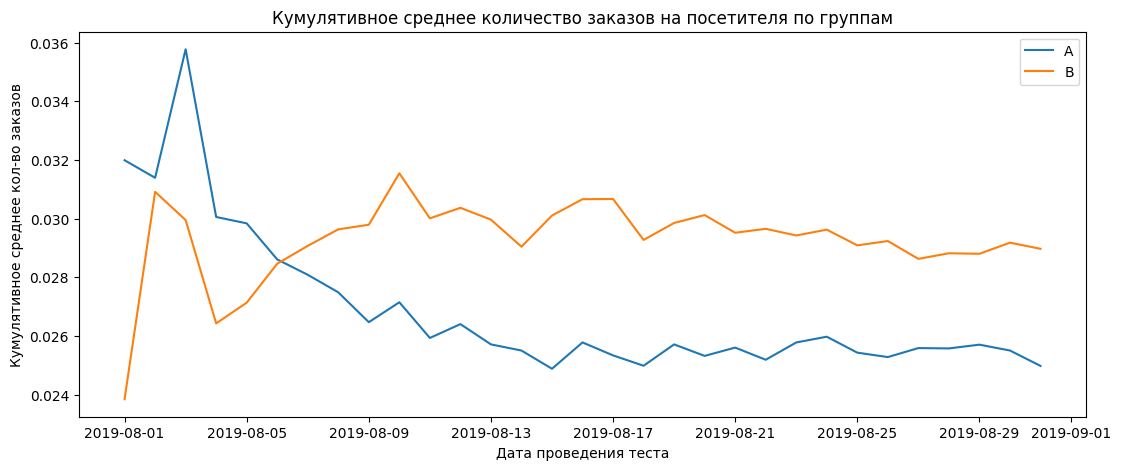

In [28]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(13, 5))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

#прописываем оси и названия
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xlabel('Дата проведения теста') 
plt.ylabel('Кумулятивное среднее кол-во заказов')

plt.legend();

**Промежуточный вывод**

* В начале наблюдений группы колебались, но затем у группы `B` среднее количество заказов вырвалось вперёд и зафиксировалось
* У группы `A` — просело, но тоже зафиксировалось.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

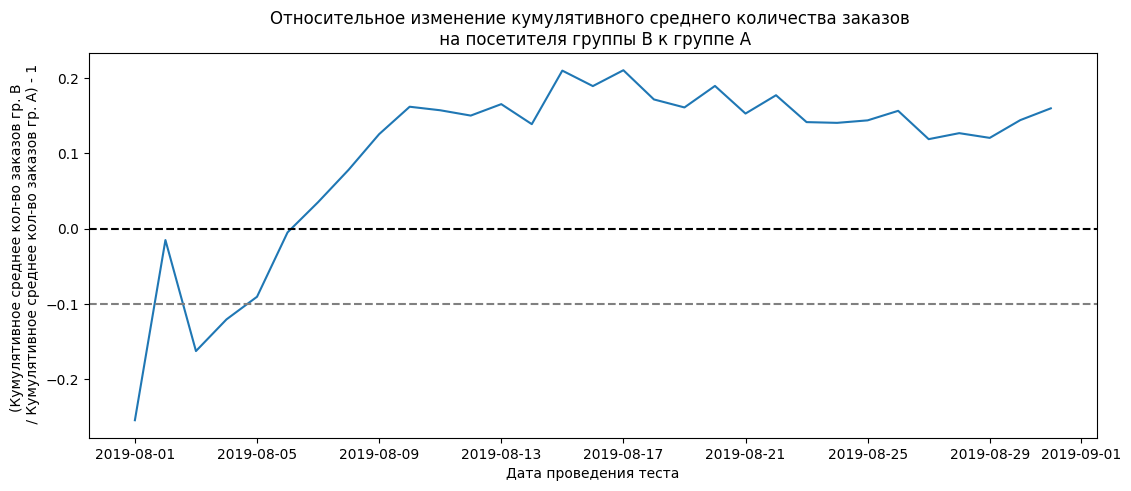

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],
                                                                           left_on='date',
                                                                           right_on='date',
                                                                           how='left',
                                                                           suffixes=['A', 'B'])


plt.figure(figsize=(13, 5))

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']
         /mergedCumulativeConversions['conversionA']-1
         )

#прописываем оси и названия
plt.title('Относительное изменение кумулятивного среднего количества заказов \n на посетителя группы B к группе A')
plt.xlabel('Дата проведения теста') 
plt.ylabel('(Кумулятивное среднее кол-во заказов гр. B \n / Кумулятивное среднее кол-во заказов гр. А) - 1')


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--');

**Промежуточный вывод**

* В начале тест группы `B` проигрывает группе `A`, затем вырывается вперед.
* После 6 августа в группе `B` стабильно больше заказов, чем в группе `A`, после 10-го августа это преимущество колеблется в районе 10-20%

#### Точечный график количества заказов по пользователям

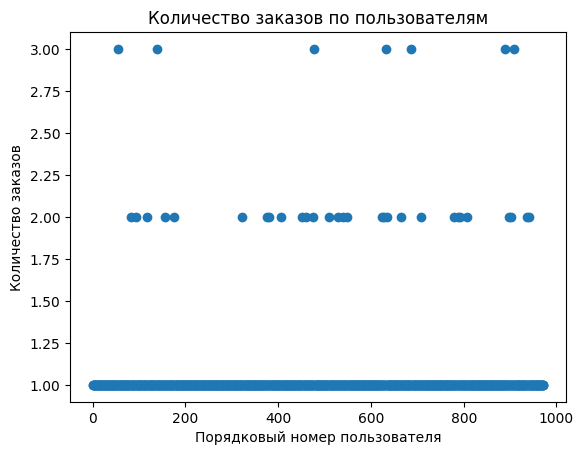

In [30]:
#сортируем датафрейм orders с группировкой по пользователям и считаем кол-во заказов
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

#создаем порядковые номера для оси x графика
x_values = pd.Series(range(0,len(ordersByUsers)))

#прописываем оси и названия
plt.title('Количество заказов по пользователям')
plt.xlabel('Порядковый номер пользователя') 
plt.ylabel('Количество заказов')

plt.scatter(x_values, ordersByUsers['orders']);

**Промежуточный вывод**

* Есть несколько пользователей, с аномально большим количеством заказов
* В основном пользователи заказывают 1-2 заказа, гораздо реже — 3 и более.

Так как принято отсеивать от 1% до 5% наблюдений с крайними значениями, уточним 95-й и 99-й перцентили количества заказов на пользователя. 

#### Расчет 95-й и 99-й перцентили количества заказов на пользователя

*Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.*

In [31]:
print('95% перцентиль количества заказов на пользователя —', np.percentile(ordersByUsers['orders'],[95])[0])
print('99% перцентиль количества заказов на пользователя —', np.percentile(ordersByUsers['orders'],[99])[0])

95% перцентиль количества заказов на пользователя — 1.0
99% перцентиль количества заказов на пользователя — 2.0


**Промежуточный вывод**

* Не более 5% пользователей оформляли больше чем 1 заказа.
* 1% пользователей заказывали более двух раз.

**Выберем 2 заказа за верхнюю границу числа заказов, и отсеим аномальных пользователей по ней.**

#### Точечный график стоимостей заказов

Text(0, 0.5, 'Стоимость')

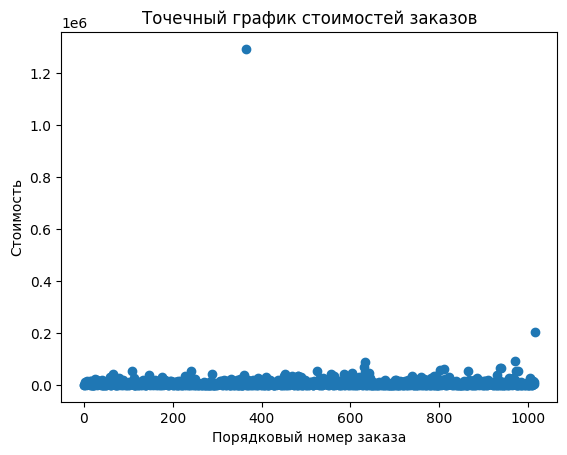

In [32]:
#создаем порядковые номера для оси x графика
x_values = pd.Series(range(0,len(orders['revenue'])))
#рисуем график
plt.scatter(x_values, orders['revenue'])

#прописываем оси и названия
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Порядковый номер заказа') 
plt.ylabel('Стоимость')

По графику виден один аномально крупный заказ, но из-за него остальные данные на графике смешались. Приблизим нижнюю границу оси Y, ограничив ее значения.

Text(0, 0.5, 'Стоимость')

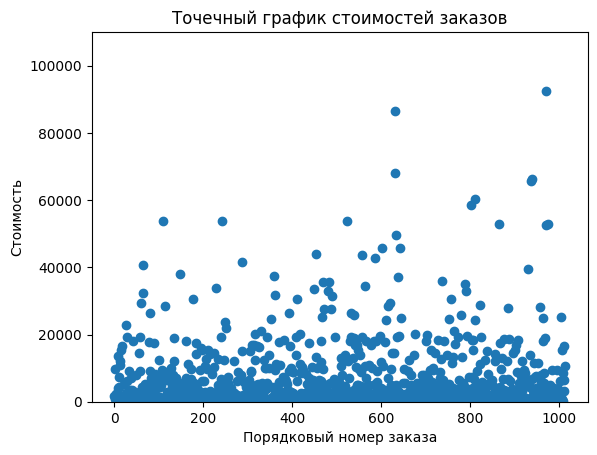

In [33]:
plt.scatter(x_values, orders['revenue']) 
plt.ylim(0, 110000)

#прописываем оси и названия
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Порядковый номер заказа') 
plt.ylabel('Стоимость')

**Промежуточный вывод**

* Есть несколько аномально дорогих заказов
* По графику можно выбрать границу аномальных заказов между 40 000 и 60 000 рублей

Так как принято отсеивать от 1% до 5% наблюдений с крайними значениями, уточним 95-й и 99-й перцентили стоимости заказов.

#### Расчет 95-й и 99-й перцентили стоимости заказов

*Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.*

In [34]:
print('95% перцентиль стоимости заказов —', int(np.percentile(orders['revenue'],[95])[0]))
print('99% перцентиль стоимости заказов —', int(np.percentile(orders['revenue'],[99])[0]))

95% перцентиль стоимости заказов — 26785
99% перцентиль стоимости заказов — 53904


**Промежуточный вывод**

* Не более 5% заказов более чем на 26 785
* 1% заказов крупнее 53 904

**Выберем 40 000 за верхнюю границу числа заказов, и отсеим аномальных пользователей по ней.**

#### Расчет стат. значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

**Сформулируем гипотезy**

**Нулевая гипотеза** - различий в среднем количестве заказов между группами нет\
**Альтернативная гипотеза** — различия в среднем между группами есть\
Таким образом альтернативная гипотеза — двусторонняя.

Зададим стат. значимость, **α = 5%**\
Для сравнения будем использовать **тест Уилкоксона-Манна-Уитни**

---

Начнём с подготовки данных.

<div class="alert alert-info">⚠️ В ячейках ниже частично используется код из главы теории Яндекс.Практикум</div>

In [35]:
#создаем таблицу с количеством посетителей по дате для группы А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

#создаем таблицу кумулятивного кол-ва пользователей для группы А
visitorsACummulative = cumulativeData.query('group == "A"')[['date','visitors']]
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

#создаем таблицу с количеством посетителей по дате для группы B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

#создаем таблицу кумулятивного кол-ва пользователей для группы B
visitorsBCummulative = cumulativeData.query('group == "B"')[['date','visitors']]
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#создаем таблицу с общим количеством заказов и общей суммой по датам для группы А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#создаем таблицу с кумулятивным количеством заказов и кумулятивной суммой по датам для группы А
ordersACummulative = cumulativeData.query('group == "A"')[['date','orders','revenue']]

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

#создаем таблицу с общим количеством заказов и общей суммой по датам для группы B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#создаем таблицу с кумулятивным количеством заказов и кумулятивной суммой по датам для группы B
ordersBCummulative = cumulativeData.query('group == "B"')[['date','orders','revenue']]

ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

#соединяем полученные таблицы воедино
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

#выведем первые строки полученной таблицы на экран
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [36]:
#создаем таблицу с количеством заказов для каждого посетителя для группы A
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

#создаем таблицу с количеством заказов для каждого посетителя для группы B
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

In [37]:
#создаем семпл с количеством заказов по пользователей для группы А
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#создаем семпл с количеством заказов по пользователей для группы B
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#Считаем и выводим на экран p-value
print('p-value равен ',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

alpha = 0.05 # задаем уровень статистической значимости

if (stats.mannwhitneyu(sampleA, sampleB)[1] < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 


print('\n* для "сырых" данных\n(Cреднее число заказов гр. B / среднее число заказов гр. A) - 1 = '
      ,"{0:.3f}".format(sampleB.mean()/sampleA.mean() - 1))

p-value равен  0.011
Отвергаем нулевую гипотезу

* для "сырых" данных
(Cреднее число заказов гр. B / среднее число заказов гр. A) - 1 =  0.160


**Промежуточный вывод**

* По «сырым» данным полученное значение p-value меньше заданного уровня значимости, есть основания предположить, что среднее количество заказов на посетителя между группами разные.

* Относительный выигрыш группы `B` равен 16%

#### Расчет стат. значимости различий в среднем чеке заказа между группами по «сырым» данным

---

**Сформулируем гипотезу**

**Нулевая гипотеза** - различий в среднем чеке заказа между группами нет\
**Альтернативная гипотеза** — различия среднем чеке заказа между группами есть\
Таким образом альтернативная гипотеза — двусторонняя.

Зададим стат. значимость, **α = 5%**\
Для сравнения будем использовать **тест Уилкоксона-Манна-Уитни**

---


In [38]:
print('p-value равен ','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

if (stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1] < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

print('\n* для "сырых" данных\n(Средний чек гр. B / средний чек гр. A) - 1 = ','{0:.3f}'
      .format(orders[orders['group']=='B']['revenue']
              .mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value равен  0.829
Не отвергаем нулевую гипотезу

* для "сырых" данных
(Средний чек гр. B / средний чек гр. A) - 1 =  0.287


**Промежуточный вывод**

* По «сырым» данным полученное значение p-value гораздо больше заданного уровня значимости, есть основания предположить, что средний чек заказа  между группами `A` и `B` — одинаковые

* При этом относительный выигрыш группы `B` равен 28.7%

#### Расчет стат. значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

---

**Сформулируем гипотезy**

**Нулевая гипотеза** - различий в среднем количестве заказов между группами нет\
**Альтернативная гипотеза** — различия в среднем между группами есть\
Таким образом альтернативная гипотеза — двусторонняя.

Зададим стат. значимость, **α = 5%**\
Для сравнения будем использовать **тест Уилкоксона-Манна-Уитни**


---


Для начала отбросим выбросы:
Выше мы выяснили что аномальными считаются:
* пользователи, совершившие более трех заказов
* заказы крупнее 40 000
---


Узнаем, сколько всего аномальных пользователей атрибутом shape.


In [39]:
#создаем общую таблицу пользователей с более чем тремя заказами
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)

#создаем общую таблицу заказов дороже 40 000 
usersWithExpensiveOrders = orders[orders['revenue'] > 40000]['visitor_id']

#создаем общую таблицу с аномальными значениями
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))

#считаем количество аномальных пользователей
abnormalUsers.shape[0]

1099    148427295
33      249864742
684     358944393
648     382846391
58      611059232
Name: visitor_id, dtype: int64

30

Всего 30 аномальных пользователей

Отфильтруем этих пользователей и получим "очищенные" данные.

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

In [40]:
#фильтруем сэмпл для группы A
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#фильтруем сэмпл для группы B
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Теперь можно посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [41]:
print('p-value равен ',"{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

alpha = 0.05 # уровень статистической значимости
if (stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 


print('\n* для "очищенных" данных\n(Cреднее число заказов гр. B / среднее число заказов гр. A) - 1 = '
      ,"{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value равен  0.004
Отвергаем нулевую гипотезу

* для "очищенных" данных
(Cреднее число заказов гр. B / среднее число заказов гр. A) - 1 =  0.205


**Промежуточный вывод**

Результат получился схожим с расчетом по "сырым" данным

* По «очищенным» данным полученное значение p-value меньше заданного уровня значимости, есть основания предположить, что среднее количество заказов на посетителя между группами разные.

* Однако относительный выигрыш группы `B` равен 20.5%

#### Расчет стат. значимости различий в среднем чеке заказа между группами по «очищенным» данным

*Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.*

---

**Сформулируем гипотезу**

**Нулевая гипотеза** — различий в среднем чеке заказа между группами нет\
**Альтернативная гипотеза** — различия среднем чеке заказа между группами есть\
Таким образом альтернативная гипотеза — двусторонняя.

Зададим стат. значимость, **α = 5%**\
Для сравнения будем использовать **тест Уилкоксона-Манна-Уитни**

---

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

In [42]:
#расчитываем p_value
p_value = '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )

#расчитываем отношение среднего чека группы B к группе A
dif = "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )

#выводим результат на экран
print('p-value равен ',p_value)

if (float(p_value) < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

print('\n* для "очищенных" данных\n(Средний чек гр. B / средний чек гр. A) - 1 = ',dif)

p-value равен  0.937
Не отвергаем нулевую гипотезу

* для "очищенных" данных
(Средний чек гр. B / средний чек гр. A) - 1 =  0.055


**Промежуточный вывод**

Результат получился схожим с расчетом по "сырым" данным

* По «очищенным» данным полученное значение p-value гораздо больше заданного уровня значимости, есть основания предположить, что средний чек заказа  между группами `A` и `B` — одинаковые

* При этом относительный выигрыш группы `B` равен 5.5%. Доля относительно 'сырых' данных сильно уменьшилась, видимо как раз тут сильно повлияли аномально дорогие заказы.

#### Принятие решения по результатам теста

*Примите решение по результатам теста и объясните его.*

Сравним результаты тестов:

<br>
<center><b>Расчет стат. значимости различий<br>
в среднем количестве заказов на посетителя между группами</b></center>

|                   |p_value            |(среднее гр. B/ среднее гр. A) -1 | 
|-------------------|-------------------|----------------------------------|
|'сырые' данные     | 0.110              |0.160                             | 
|'очищенные' данные | 0.004             |0.205                             |

---


<br>
<center><b>
Расчет стат. значимости различий в среднем чеке заказа</b></center>

|                   |p_value            |(среднее гр. B/ среднее гр. A) -1 | 
|-------------------|-------------------|----------------------------------|
|'сырые' данные     | 0.829             |0.287                             | 
|'очищенные' данные | 0.937             |0.055                             |


---

Еще раз взглянем на графики:

* различия среднего количества заказов между группами 
* различия среднего чека между группами 

<div class="alert alert-info">⚠️ В ячейке ниже частично используется код из главы теории Яндекс.Практикум</div>

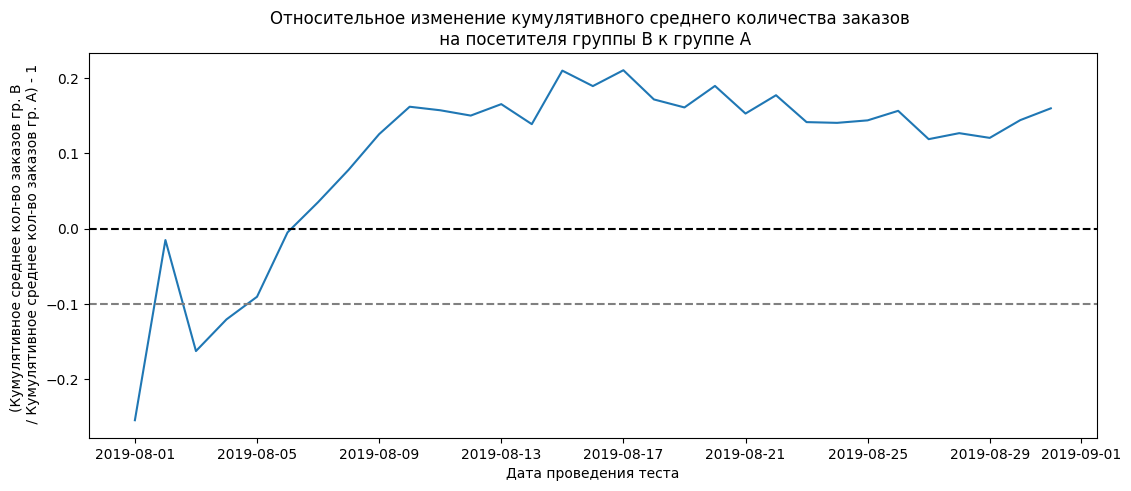

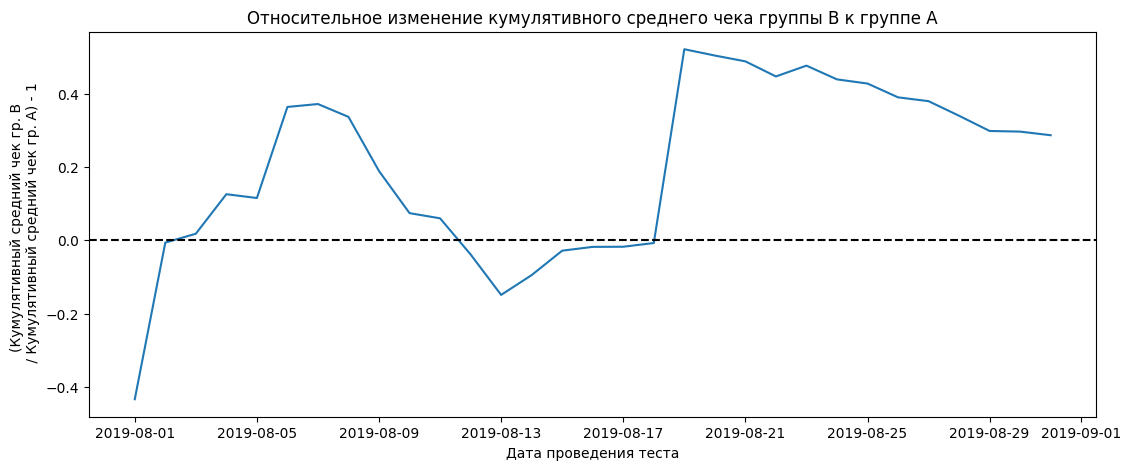

In [43]:
plt.figure(figsize=(13, 5))

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']
         /mergedCumulativeConversions['conversionA']-1
         )

#прописываем оси и названия
plt.title('Относительное изменение кумулятивного среднего количества заказов \n на посетителя группы B к группе A')
plt.xlabel('Дата проведения теста') 
plt.ylabel('(Кумулятивное среднее кол-во заказов гр. B \n / Кумулятивное среднее кол-во заказов гр. А) - 1')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.show()

# cтроим отношение средних чеков
plt.figure(figsize=(13, 5))

plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']
          /mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']
           /mergedCumulativeRevenue['ordersA'])-1)

#прописываем оси и названия
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата проведения теста') 
plt.ylabel('(Кумулятивный средний чек гр. B \n / Кумулятивный средний чек гр. А) - 1')


# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.show();

**Выводы:**
* Есть значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий. Разница между сегментами равна 16% для "сырых" и 20,5% для "очищенных" данных в пользу группы `B` 


* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Разница между сегментами равна 28,7% для "сырых" и 5.5% для "очищенных" данных в пользу группы `B` 


* График различия среднего количества заказов между группами сообщает, что результаты группы `B` стабильно лучше группы `А` на 10-20%

* График различия среднего чека между группами сообщает, что результаты группы `B` в конце и начале наблюдений  лучше группы `А`. При этом график резко проседает после 7 августа и резко растет 19-го. После 19-го и до конца периода наблюдений отношение понемногу падает. Отношение (B/A-1) почти все время больше ноля (30% к концу наблюдений).


**Принятие решения:**
**Остановить тест, зафиксировать победу группы `B`.**


### Общий вывод

В ходе исследования:

**`В рамках предобработки данных:`**

* заменили названия столбцов на подходящие
* исправили типы данных, где это необходимо
* проверили датасеты на наличие явных и неявных дубликатов и пропусков
---

**`Провели приоритизацию полученных гипотез:`**

Применили два способа приоритизации гипотез RICE и ICE. 

* При применении способа ICE в топ 3 попали гипотезы №№ 8,0,7, с №8 на первом месте.
* После применения способа RICE на первое место по приоритетности вышла гипотеза №7
№8 ушла в середину списка, 0 остался в топ 3, также в топ 3 поднялась гипотеза под номером №2
(На изменение положения гипотез в шкале приоритетности повлиял параметр `reach` (англ. «охват»).)

**`Провели анализ A/B-теста`**

**Приняли решение: остановить тест, зафиксировать победу группы `B`.**

Основания для принятия решения мы получили на основе графиков, а так же расчета стат. значимости для среднего чека и средней суммы заказов между группами. Для расчета стат. значимости мы использовали как 'сырые', так и 'очищенные'
от аномалий данные. Дополнительно считали относительную разницу средних значений `B` к `А`

Выводы получились следующими:

* Есть значимое различие по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий. Разница между сегментами равна 16% для "сырых" и 20,5% для "очищенных" данных в пользу группы `B` 

* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Разница между сегментами равна 28,7% для "сырых" и 5.5% для "очищенных" данных в пользу группы `B` 

* График различия среднего количества заказов между группами сообщает, что результаты группы `B` стабильно лучше группы `А` на 10-20%

* График различия среднего чека между группами сообщает, что результаты группы `B` в конце и начале наблюдений  лучше группы `А`. Отношение (B/A-1) почти все время больше ноля (30% к концу наблюдений).

**`Рекомендации для отдела маркетинга`**

* Следует обратить внимание на гипотезу №7, как на наиболее приоритетную, а также обладающую наибольшим охватом (10 из 10 пунктов)

* Признать A/B-тест успешным и реализовать изменения, характерные для группы B
